In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
%load_ext autoreload
%autoreload 2
from ieee80211phy.transmitter.main import tx_generator
from ieee80211phy.receiver.packet_detector import *
from ieee80211phy.receiver.frequency_correction import *
from ieee80211phy.receiver.timing_acqusition import *
from ieee80211phy.util import *
import scipy 

import warnings
warnings.filterwarnings('ignore') # yolo!

In [2]:
# pad_len = 100000
# noise = 0.00001 *  (0.70711 * np.random.randn(pad_len) + 0.70711 * np.random.randn(pad_len)*1j)

# to_tx = np.concatenate([tx, noise])

# def save_complex64_file(file: str, iq: np.array):
#     out = iq.astype(sp.complex64)
#     out.tofile(file)
#     return
# save_complex64_file('tx.raw', to_tx)
# plt.figure(figsize=(9.75,5))
# plt.plot(to_tx)
# plt.tight_layout()
# plt.grid()

# TX packet

In [3]:
np.random.seed(0)
data = ''.join('1' if x else '0' for x in np.random.randint(2, size=20906))
tx, maps, ofdm_syms = tx_generator(data, data_rate=36)

pad_len = 128
noise = 0.00001 *  (0.70711 * np.random.randn(pad_len) + 0.70711 * np.random.randn(pad_len)*1j)
tx = np.concatenate([noise, tx])



plt.figure(figsize=(9.75,5))
plt.plot(tx)
plt.tight_layout()
plt.grid()


plt.figure(figsize=(9.75,5))
plt.scatter(maps.real, maps.imag)
plt.tight_layout()
plt.grid()
print(maps.shape)

Symbols: 109 Padding: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(5232,)


# Channel

In [4]:
def show_freqz(taps):
    import matplotlib.pyplot as plt
    from scipy import signal
    w, h = signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
N = 128  # Filter order
bands = np.array([0., .22, .28, .5]) # Filter symetric around 0.25 (where .5 is pi or Fs/2)
halfband_taps =  signal.remez(N+1, bands, [1,0], [1,1])
halfband_taps[abs(halfband_taps) <= 1e-4] = 0.
show_freqz(halfband_taps)

<IPython.core.display.Javascript object>

In [5]:
def channel(tx, snr, freq_offset):
    up = scipy.signal.resample_poly(tx, 2, 1, window=halfband_taps)

    up = mixer(up, freq_offset, 40e6)
    rx = awgn(up, snr)

    rx = scipy.signal.resample_poly(rx, 1, 2, window=halfband_taps)
    return rx

# Packet detection

In [58]:
rx = channel(tx, snr=40, freq_offset=0)
# rx = tx
start_of_long_training, ratio = packet_detector(rx, debug=False)
print(start_of_long_training)

288


# Freq offset detection

In [59]:
ENABLE_FREQ = False
fixed_rx = rx
if ENABLE_FREQ:
    fixed_rx, error_coarse = fix_frequency_offset_coarse(rx, start_of_long_training, debug=True)
#     fixed_rx, error_fine = fix_frequency_offset_fine(fixed_rx, start_of_long_training, debug=True)
    print(f'Total error corrected: {error_coarse + error_fine}')

# Equalizer

In [60]:
from ieee80211phy.receiver.equalizer import *
equal = Equalizer(sample_advance=0)
equal.train(fixed_rx, start_of_long_training, debug=False)

# RX

<IPython.core.display.Javascript object>


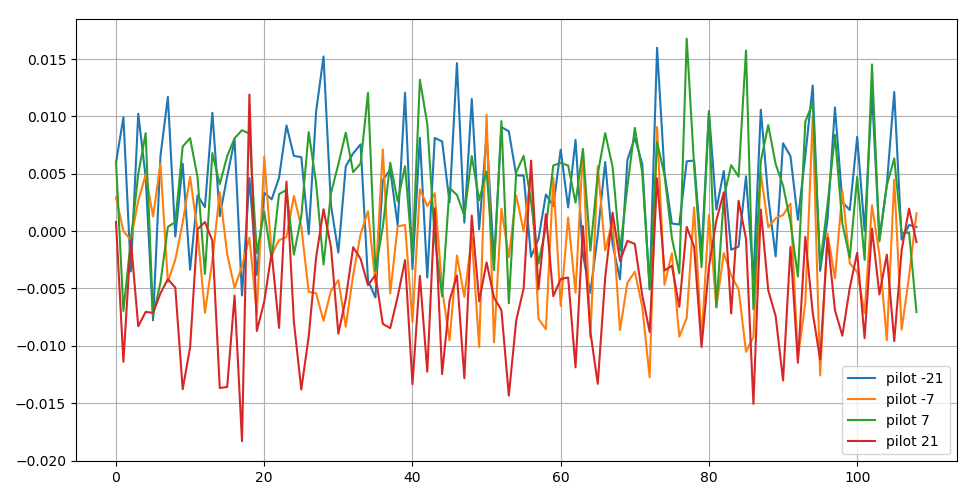

<IPython.core.display.Javascript object>


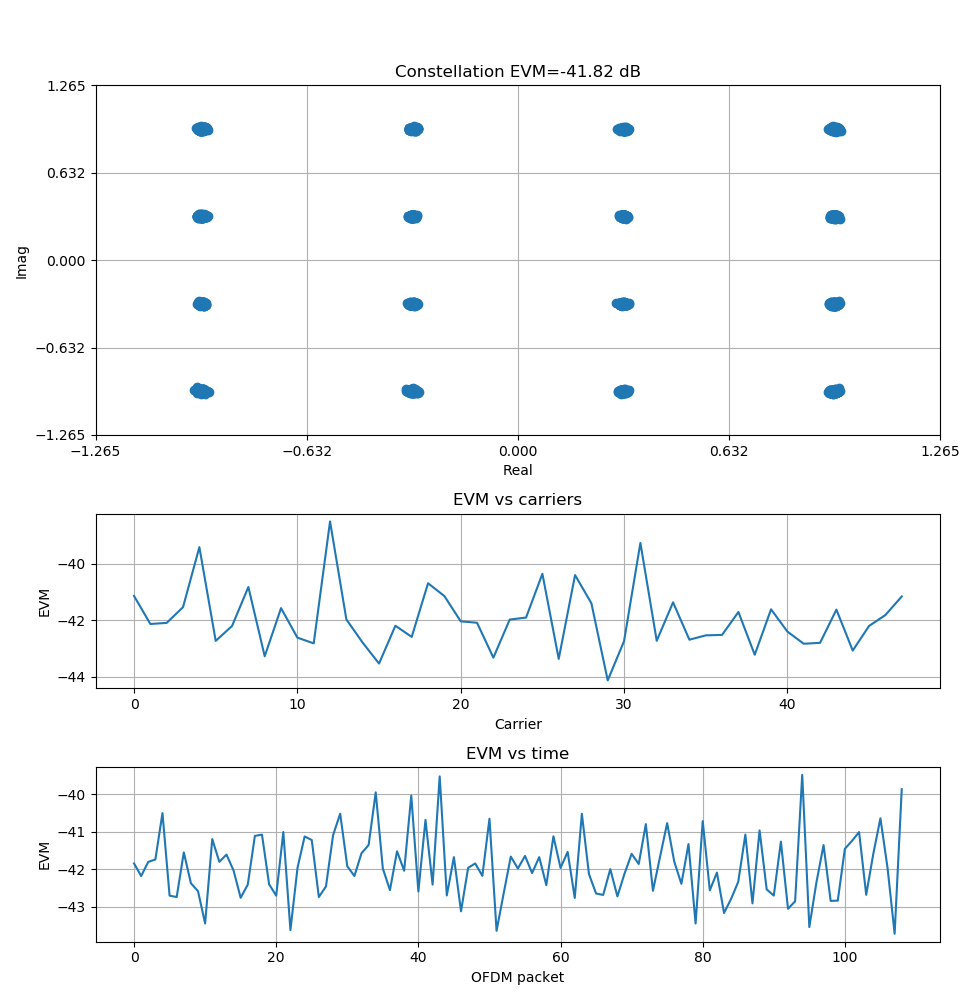

In [61]:
rx_symbols = demod_data(fixed_rx, start_of_long_training, 109, equal, debug=True)
plot_rx(rx_symbols, ofdm_syms)

In [9]:
rx_symbols, pilots = demod_data(fixed_rx, start_of_long_training, 109, equal)
polarity = [1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1,
            -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1,
            -1, -1,
            1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1,
            -1,
            1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1,
            -1, -1, -1,
            -1, -1]

ang1 = []
ang2 = []
ang3 = []
ang4 = []
avg = []
for i, x in enumerate(pilots):
    p0 = x[0] * polarity[i+1]
    p1 = x[1] * polarity[i+1]
    p2 = x[2] * polarity[i+1]
    p3 = -x[3] * polarity[i+1]
    
    avg_p = (p0 + p1 + p2 + p3) / 4
    p_angle = np.angle(avg_p)
    ang1.append(np.angle(x[0] * polarity[i+1]))
    ang2.append(np.angle(x[1] * polarity[i+1]))
    ang3.append(np.angle(x[2] * polarity[i+1]))
    ang4.append(np.angle(-x[3] * polarity[i+1]))
#     avg.append((ang1[-1] + ang2[-1] + ang3[-1] + ang4[-1]) / 4)
    avg.append(p_angle)
    
    
plt.figure(figsize=(9.75,5))
plt.plot(ang1, label='pilot -21')
plt.plot(ang2, label='pilot -7')
plt.plot(ang3, label='pilot 7')
plt.plot(ang4, label='pilot 21')
plt.plot(avg, label='average')
plt.tight_layout()
plt.legend()
plt.grid()

mean_avg = np.mean(np.diff(avg))
print(mean_avg, np.exp(-1j*mean_avg))


fixed_symbols = [rx_symbols[i] * np.exp(-1j*avg[i]) for i in range(len(rx_symbols))]

# rx_symbols = rx_symbols + np.array(avg).expand_dims()
plot_rx(fixed_symbols, ofdm_syms)

ValueError: too many values to unpack (expected 2)

In [ ]:
# from ieee80211phy.transmitter.ofdm_modulation import *

# no_head = rx[384+64:-1 - sample_advance]
# symbols = np.reshape(no_head, (-1, 80))
# freq = [np.fft.fft(x[16:]) for x in symbols]

# equalized = freq
# # print(equalizer_coefs)
# # equalized = [x * equalizer_coefs for x in freq]
# symbols = np.array([demap_from_carriers(x) for x in equalized])

# symbols_flat = symbols.flatten()


In [ ]:
# from ieee80211phy.util import *
# plot_rx(symbols, ofdm_syms)

In [ ]:
# plt.figure(figsize=(9.75,5))
# plt.plot(symbols)
# plt.plot(maps)
# plt.tight_layout()
# plt.grid()

In [ ]:
# from ieee80211phy.transmitter.subcarrier_modulation_mapping import *
# # symbols = np.array([QAM16_LUT_NORM[i>>2] + QAM16_LUT_NORM[i&3] * 1j for i in range(16)])
# symbols = np.array([QAM64_LUT_NORM[i>>3] + QAM64_LUT_NORM[i&7] * 1j for i in range(64)])
# print(symbols)
# pwr = [power(x) for x in symbols]
# print(pwr, np.mean(pwr))

# plt.figure(figsize=(9.75,5))
# plt.scatter(symbols.real, symbols.imag)
# plt.tight_layout()
# tick_base = 1 / np.sqrt(10)
# plt.xticks([-4*tick_base, -2*tick_base, 0, tick_base*2, tick_base*4])
# plt.yticks([-4*tick_base, -2*tick_base, 0, tick_base*2, tick_base*4])
# plt.grid()